In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates'
sys.path.append(my_path)
os.listdir(my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataTorchTransformLoad.py',
 'Plots.py',
 'Resnet.py',
 'README.md',
 'GradCam.py',
 'VS_NET.py',
 '02_CIFAR+Resnet _Gradcam.ipynb',
 'QuizDNN.py',
 'EVA5 Assignment 9a',
 'outputs',
 '__pycache__',
 'dataAlbumentationLoad.py',
 'best_model.pt',
 '03_LR_Finder_CIFAR_RESNET_CAM.ipynb',
 'Test_Train.py',
 '03_LR_Finder_CIFAR_RESNET_CAM - V2.ipynb']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import sys
import random
import matplotlib


# import for all the modular codes
import VS_NET
import Test_Train
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import GradCam
import Resnet
import dataAlbumentationLoad as dal
#import GradCam



In [3]:
# -*- coding: utf-8 -*-
"""gradcam.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/15jNC5H3pI6Dd0UMS9fcREpMcMB7F9ljl
"""

import torch
import torch.nn.functional as F
import cv2

class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: input image with shape of (1, 3, H, W)
        class_idx (int): class index for calculating GradCAM.
                If not specified, the class index that makes the highest model prediction score will be used.
    Return:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        gradcam = GradCAM.from_config(model_type='resnet', arch=resnet, layer_name='layer4')
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    """

    def __init__(self, model, layer_name):
        self.model = model
        # self.layer_name = layer_name
        self.target_layer = layer_name

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        
        self.gradients.clear()
        self.activations.clear()
        return saliency_map, logit
    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

"""VISUALIZE_GRADCAM"""

def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


# functions to show an image

# def imageshow(img):
#     # img = img / 2 + 0.5      #unnormalize
#     img[0] = img[0]*0.24703223 + 0.49139968
#     img[1] = img[1]*0.24348513 + 0.48215841
#     img[2] = img[2]*0.26158784 + 0.44653091
#     npimg = img.numpy()
#     plt.figure(figsize=(20,20))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    plt.imshow(image)
    plt.grid(b=None)
    return image

def imshow1(img,c = "" ):
  #img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(c)
  plt.grid(b=None)

In [4]:
# # Modelling options for the loop


# d1 = {'NO L1&L1': [0.,0.,'model'],
#       'L1 Only': [1e-04,0.,'model'], 
#       'L2 Only': [0.,1e-04,'model'],
#       'L1&L2':[1e-04,1e-04,'model'],
#       'GBN Only': [0,0,'model2'],
#       'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
start_epoch=0
EPOCHS = 35
EPOCHS1 = 50
input_ch=3
best_acc = 85

metric_values = {}
models={}

batch_size_GPU=64
batch_size_CPU=16

model_save_path = my_path+"/best_model.pt"




In [5]:
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = dal.AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1 )
                                       ])
# # Test Phase transformations
test_transform = dal.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [6]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation((-5.0, 5.0),fill=1), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                           transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [7]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [9]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


<Figure size 432x288 with 0 Axes>

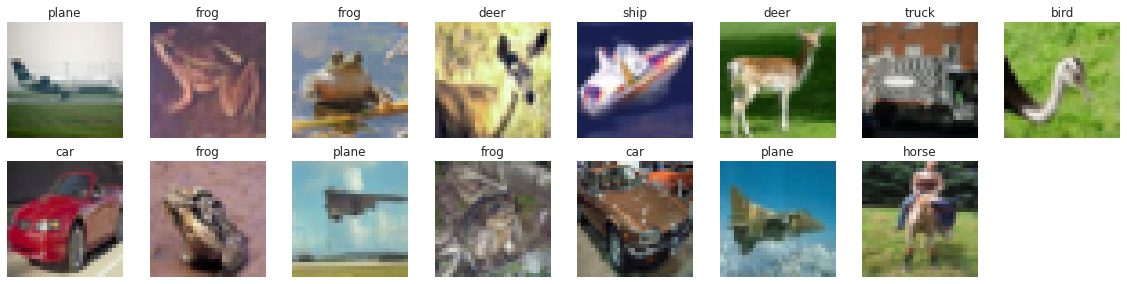

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')


figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

#RESNET

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)

In [12]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


# LR Finder

In [12]:
# !pip install torch_lr_finder
from torch_lr_finder import LRFinder

model = model
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=1e-03,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=0.5, num_iter=100 ,step_mode="exp")


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 7.00E-03


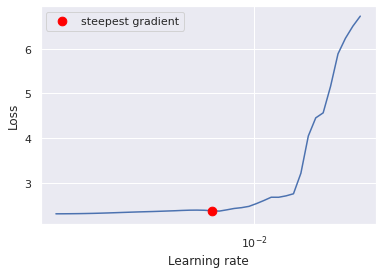

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe92048d048>,
 0.007000547739229602)

In [13]:
lr_finder.plot(log_lr=True)

In [19]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
lr_finder.reset()

In [11]:
ideal_lr=0.001

In [12]:
ideal_lr

0.001

In [13]:

# # Uses Step lr to change the learning rate
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

# Uses Reduce on plateu option for changing the learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9, nesterov=False)
scheduler = ReduceLROnPlateau(optimizer, patience = 3)



In [14]:
exp_name = 'Resnet'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.001


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=1.0829854011535645 Batch_id=781 Accuracy=45.50: 100%|██████████| 782/782 [00:59<00:00, 13.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3325, Accuracy: 5247/10000 (52.47%)

emptying the cache
EPOCH: 1
learning rate  0.001


Loss=0.6057994961738586 Batch_id=781 Accuracy=61.38: 100%|██████████| 782/782 [00:59<00:00, 13.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0984, Accuracy: 6210/10000 (62.10%)

EPOCH: 2
learning rate  0.001


Loss=0.7790781855583191 Batch_id=781 Accuracy=68.59: 100%|██████████| 782/782 [00:59<00:00, 13.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7646, Accuracy: 7288/10000 (72.88%)

EPOCH: 3
learning rate  0.001


Loss=1.418454885482788 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [00:59<00:00, 13.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6398, Accuracy: 7780/10000 (77.80%)

EPOCH: 4
learning rate  0.001


Loss=1.1547677516937256 Batch_id=781 Accuracy=76.29: 100%|██████████| 782/782 [00:59<00:00, 13.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6420, Accuracy: 7744/10000 (77.44%)

EPOCH: 5
learning rate  0.001


Loss=0.4336415231227875 Batch_id=781 Accuracy=78.75: 100%|██████████| 782/782 [00:59<00:00, 13.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6655, Accuracy: 7797/10000 (77.97%)

EPOCH: 6
learning rate  0.001


Loss=0.8231278657913208 Batch_id=781 Accuracy=80.56: 100%|██████████| 782/782 [00:59<00:00, 13.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 8073/10000 (80.73%)

EPOCH: 7
learning rate  0.001


Loss=0.284626841545105 Batch_id=781 Accuracy=81.99: 100%|██████████| 782/782 [00:59<00:00, 13.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5890, Accuracy: 8007/10000 (80.07%)

EPOCH: 8
learning rate  0.001


Loss=0.2638821005821228 Batch_id=781 Accuracy=83.15: 100%|██████████| 782/782 [00:59<00:00, 13.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8274/10000 (82.74%)

EPOCH: 9
learning rate  0.001


Loss=0.4128464162349701 Batch_id=781 Accuracy=84.54: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 8417/10000 (84.17%)

EPOCH: 10
learning rate  0.001


Loss=0.3725511133670807 Batch_id=781 Accuracy=85.39: 100%|██████████| 782/782 [01:00<00:00, 12.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5222, Accuracy: 8249/10000 (82.49%)

emptying the cache
EPOCH: 11
learning rate  0.001


Loss=0.48502883315086365 Batch_id=781 Accuracy=86.76: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4819, Accuracy: 8442/10000 (84.42%)

EPOCH: 12
learning rate  0.001


Loss=0.2827342748641968 Batch_id=781 Accuracy=87.58: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s]



Test set: Average loss: 0.4629, Accuracy: 8508/10000 (85.08%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 13
learning rate  0.001


Loss=0.5212502479553223 Batch_id=781 Accuracy=88.17: 100%|██████████| 782/782 [01:00<00:00, 12.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5553, Accuracy: 8229/10000 (82.29%)

EPOCH: 14
learning rate  0.001


Loss=0.18419939279556274 Batch_id=781 Accuracy=88.96: 100%|██████████| 782/782 [01:00<00:00, 13.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5139, Accuracy: 8399/10000 (83.99%)

EPOCH: 15
learning rate  0.001


Loss=0.24244090914726257 Batch_id=781 Accuracy=89.52: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4859, Accuracy: 8498/10000 (84.98%)

EPOCH: 16
learning rate  0.001


Loss=0.586783230304718 Batch_id=781 Accuracy=90.28: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s]



Test set: Average loss: 0.4599, Accuracy: 8529/10000 (85.29%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 17
learning rate  0.001


Loss=0.38600072264671326 Batch_id=781 Accuracy=90.67: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s]



Test set: Average loss: 0.4813, Accuracy: 8609/10000 (86.09%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 18
learning rate  0.001


Loss=0.46676185727119446 Batch_id=781 Accuracy=91.24: 100%|██████████| 782/782 [01:00<00:00, 12.92it/s]



Test set: Average loss: 0.4702, Accuracy: 8518/10000 (85.18%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 19
learning rate  0.001


Loss=0.21766284108161926 Batch_id=781 Accuracy=91.83: 100%|██████████| 782/782 [01:00<00:00, 12.95it/s]



Test set: Average loss: 0.4410, Accuracy: 8656/10000 (86.56%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 20
learning rate  0.001


Loss=0.1669633686542511 Batch_id=781 Accuracy=92.18: 100%|██████████| 782/782 [01:00<00:00, 12.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5406, Accuracy: 8377/10000 (83.77%)

emptying the cache
EPOCH: 21
learning rate  0.001


Loss=0.3015437722206116 Batch_id=781 Accuracy=92.58: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s]



Test set: Average loss: 0.4414, Accuracy: 8681/10000 (86.81%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 22
learning rate  0.001


Loss=0.03441030904650688 Batch_id=781 Accuracy=93.00: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]



Test set: Average loss: 0.5008, Accuracy: 8568/10000 (85.68%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 23
learning rate  0.001


Loss=0.2642841637134552 Batch_id=781 Accuracy=93.28: 100%|██████████| 782/782 [01:00<00:00, 12.88it/s]



Test set: Average loss: 0.4637, Accuracy: 8621/10000 (86.21%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 24
learning rate  0.0001


Loss=0.12464997172355652 Batch_id=781 Accuracy=95.33: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]



Test set: Average loss: 0.3853, Accuracy: 8855/10000 (88.55%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 25
learning rate  0.0001


Loss=0.39802515506744385 Batch_id=781 Accuracy=95.99: 100%|██████████| 782/782 [01:00<00:00, 12.83it/s]



Test set: Average loss: 0.3807, Accuracy: 8902/10000 (89.02%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 26
learning rate  0.0001


Loss=0.028889214619994164 Batch_id=781 Accuracy=96.23: 100%|██████████| 782/782 [01:00<00:00, 12.89it/s]



Test set: Average loss: 0.3751, Accuracy: 8891/10000 (88.91%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 27
learning rate  0.0001


Loss=0.19923120737075806 Batch_id=781 Accuracy=96.30: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]



Test set: Average loss: 0.3795, Accuracy: 8891/10000 (88.91%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 28
learning rate  0.0001


Loss=0.29060736298561096 Batch_id=781 Accuracy=96.32: 100%|██████████| 782/782 [01:01<00:00, 12.79it/s]



Test set: Average loss: 0.3747, Accuracy: 8869/10000 (88.69%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 29
learning rate  0.0001


Loss=0.11113858968019485 Batch_id=781 Accuracy=96.61: 100%|██████████| 782/782 [01:01<00:00, 12.81it/s]



Test set: Average loss: 0.3772, Accuracy: 8888/10000 (88.88%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 30
learning rate  0.0001


Loss=0.04085727781057358 Batch_id=781 Accuracy=96.74: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]



Test set: Average loss: 0.3734, Accuracy: 8896/10000 (88.96%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 31
learning rate  0.0001


Loss=0.34495294094085693 Batch_id=781 Accuracy=96.74: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]



Test set: Average loss: 0.3761, Accuracy: 8894/10000 (88.94%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 32
learning rate  0.0001


Loss=0.04164006561040878 Batch_id=781 Accuracy=96.85: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]



Test set: Average loss: 0.3735, Accuracy: 8931/10000 (89.31%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 33
learning rate  0.0001


Loss=0.32511550188064575 Batch_id=781 Accuracy=96.83: 100%|██████████| 782/782 [01:00<00:00, 12.89it/s]



Test set: Average loss: 0.3747, Accuracy: 8906/10000 (89.06%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 34
learning rate  0.0001


Loss=0.04172445833683014 Batch_id=781 Accuracy=96.90: 100%|██████████| 782/782 [01:00<00:00, 12.87it/s]



Test set: Average loss: 0.3766, Accuracy: 8903/10000 (89.03%)

...BEST MODEL...
Save success...


# Load Saved model and train for another 10 epochs

In [10]:


# model = model.ResNet18(dropout=0.1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)

# Get the epoch number, loss and best learning rate from the best model

checkpoint = torch.load(model_save_path)
epoch = checkpoint['epoch']
loss = checkpoint['loss']
best_lr2 = checkpoint['learn_rate_last']

# declare the model, and pass the best learning rate from the previous run, reduce on plateau. 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr2,momentum=0.9 ,weight_decay = 0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience = 3)

# Load the saved model

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# best_lr2 = checkpoint['learn_rate_last']

model.eval()
print("Loaded the best model")

Loaded the best model


In [12]:
# Second run continues from end of the Epochs from previous run. 
start_epoch = EPOCHS

# change the EPOCHS to EPOCHS1 =5
trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS1,scheduler,model_save_path,best_acc)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)




  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 35
learning rate  1e-05


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=0.13091227412223816 Batch_id=781 Accuracy=97.05: 100%|██████████| 782/782 [00:59<00:00, 13.09it/s]



Test set: Average loss: 0.3744, Accuracy: 8911/10000 (89.11%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 36
learning rate  1e-05


Loss=0.06685763597488403 Batch_id=781 Accuracy=97.05: 100%|██████████| 782/782 [01:00<00:00, 12.88it/s]



Test set: Average loss: 0.3753, Accuracy: 8902/10000 (89.02%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 37
learning rate  1e-05


Loss=0.0901317298412323 Batch_id=781 Accuracy=97.16: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]



Test set: Average loss: 0.3730, Accuracy: 8906/10000 (89.06%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 38
learning rate  1e-05


Loss=0.24546028673648834 Batch_id=781 Accuracy=97.03: 100%|██████████| 782/782 [01:00<00:00, 12.89it/s]



Test set: Average loss: 0.3720, Accuracy: 8921/10000 (89.21%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 39
learning rate  1e-05


Loss=0.2135622352361679 Batch_id=781 Accuracy=97.01: 100%|██████████| 782/782 [01:00<00:00, 12.88it/s]



Test set: Average loss: 0.3716, Accuracy: 8919/10000 (89.19%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 40
learning rate  1e-05


Loss=0.08147686719894409 Batch_id=781 Accuracy=97.21: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]



Test set: Average loss: 0.3718, Accuracy: 8929/10000 (89.29%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 41
learning rate  1e-05


Loss=0.034174468368291855 Batch_id=781 Accuracy=97.17: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]



Test set: Average loss: 0.3724, Accuracy: 8914/10000 (89.14%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 42
learning rate  1e-05


Loss=0.040336210280656815 Batch_id=781 Accuracy=97.15: 100%|██████████| 782/782 [01:01<00:00, 12.79it/s]



Test set: Average loss: 0.3701, Accuracy: 8928/10000 (89.28%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 43
learning rate  1e-05


Loss=0.07415436208248138 Batch_id=781 Accuracy=97.24: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]



Test set: Average loss: 0.3723, Accuracy: 8923/10000 (89.23%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 44
learning rate  1e-05


Loss=0.12125866860151291 Batch_id=781 Accuracy=97.18: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]



Test set: Average loss: 0.3767, Accuracy: 8927/10000 (89.27%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 45
learning rate  1e-05


Loss=0.008101980201900005 Batch_id=781 Accuracy=97.04: 100%|██████████| 782/782 [01:00<00:00, 12.82it/s]



Test set: Average loss: 0.3727, Accuracy: 8924/10000 (89.24%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 46
learning rate  1e-05


Loss=0.46374592185020447 Batch_id=781 Accuracy=97.10: 100%|██████████| 782/782 [01:00<00:00, 12.83it/s]



Test set: Average loss: 0.3753, Accuracy: 8925/10000 (89.25%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 47
learning rate  1.0000000000000002e-06


Loss=0.08962080627679825 Batch_id=781 Accuracy=97.19: 100%|██████████| 782/782 [01:01<00:00, 12.82it/s]



Test set: Average loss: 0.3757, Accuracy: 8923/10000 (89.23%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 48
learning rate  1.0000000000000002e-06


Loss=0.10595572739839554 Batch_id=781 Accuracy=97.13: 100%|██████████| 782/782 [01:00<00:00, 12.89it/s]



Test set: Average loss: 0.3716, Accuracy: 8922/10000 (89.22%)

...BEST MODEL...


  0%|          | 0/782 [00:00<?, ?it/s]

Save success...
EPOCH: 49
learning rate  1.0000000000000002e-06


Loss=0.1463421881198883 Batch_id=781 Accuracy=97.21: 100%|██████████| 782/782 [01:00<00:00, 12.91it/s]



Test set: Average loss: 0.3756, Accuracy: 8912/10000 (89.12%)

...BEST MODEL...
Save success...


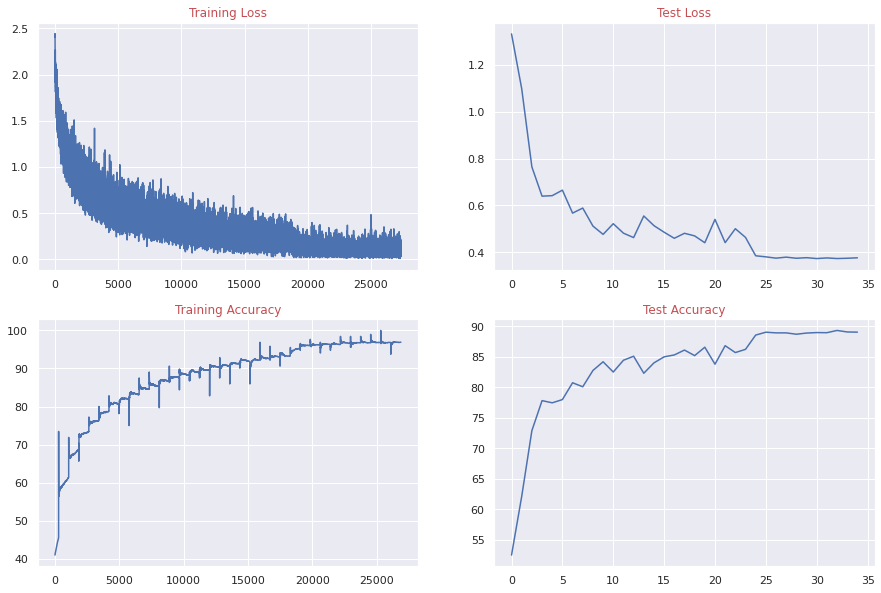

In [15]:
Plots.plot_metrics(train_metric, test_metric)

# Plot misclassified

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


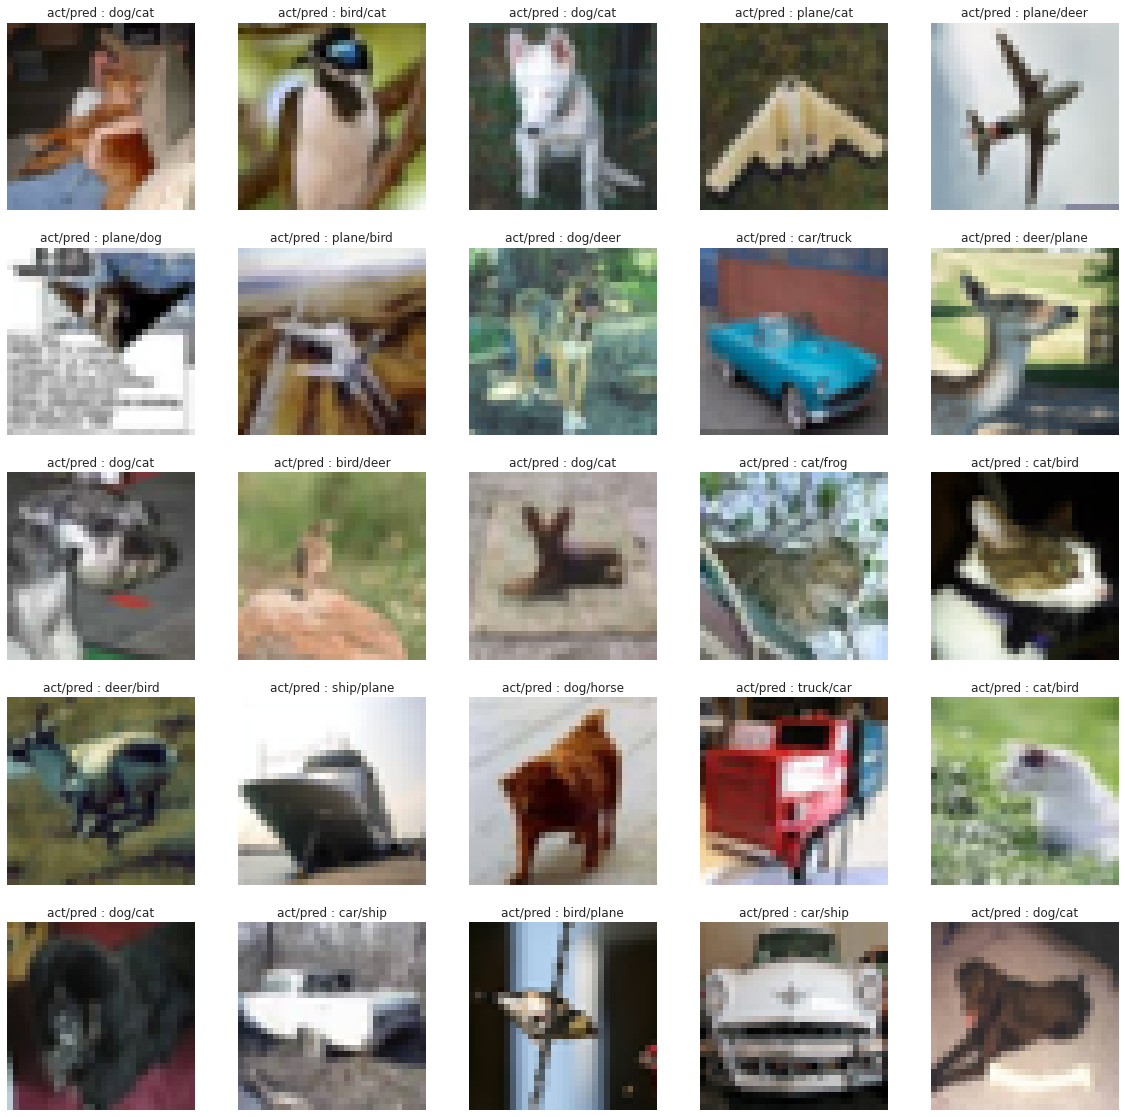

In [13]:

model.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1


In [ ]:
len(misclass_img_list)

25

In [14]:
# Save misclassified image in local directory

# misclass_img_list
mis_img_name_list = []

for i in range(len(misclass_img_list)):
  img_name = 'mis_img'+str(i+1)+'.jpeg'
  mis_img_name_list.append(img_name)
  matplotlib.image.imsave(img_name, misclass_img_list[i])
  # print(img_name)



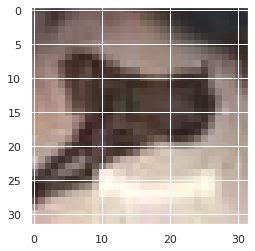

In [15]:
# Download PIL Images
import PIL

pil_image = []
for i,img in enumerate(mis_img_name_list):
   img = PIL.Image.open(img)
   pil_image.append(img)
   plt.imshow(img)


In [16]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.24703223, 0.24348513, 0.26158784])(torch_img)[None])

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/10_Advanced-Training & Learning Rates/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


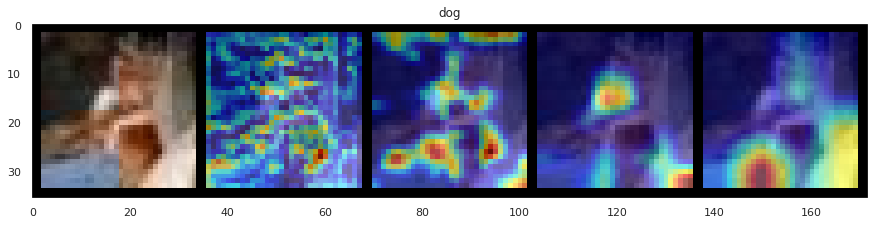

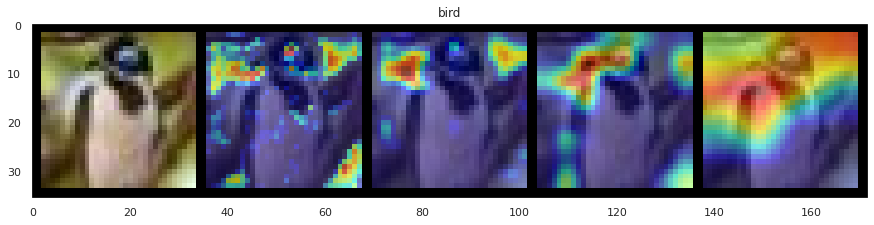

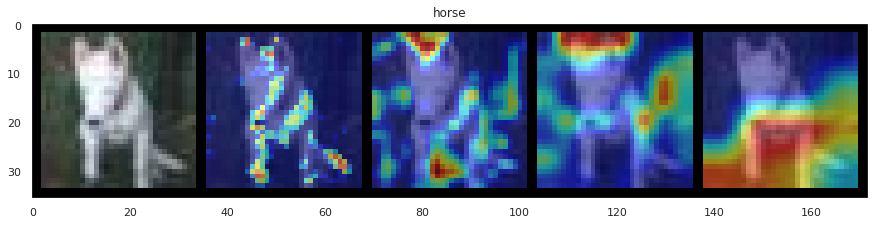

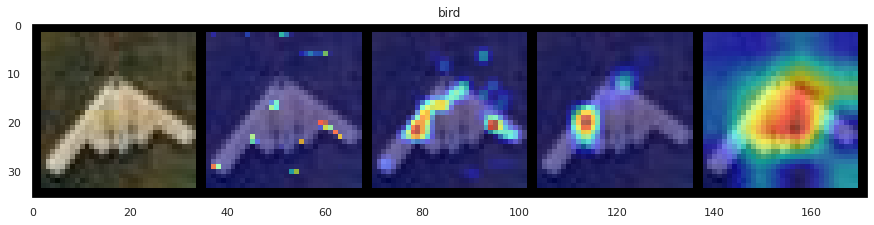

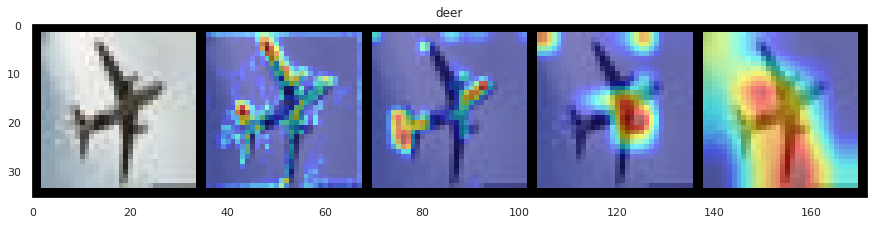

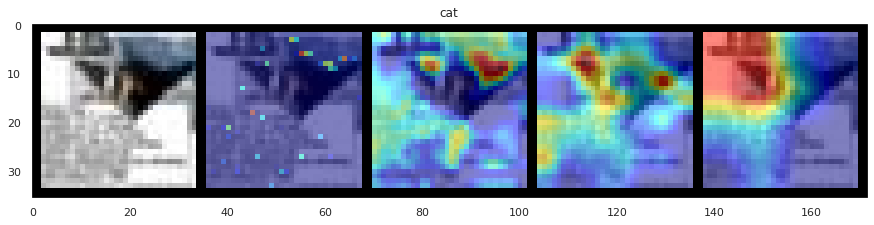

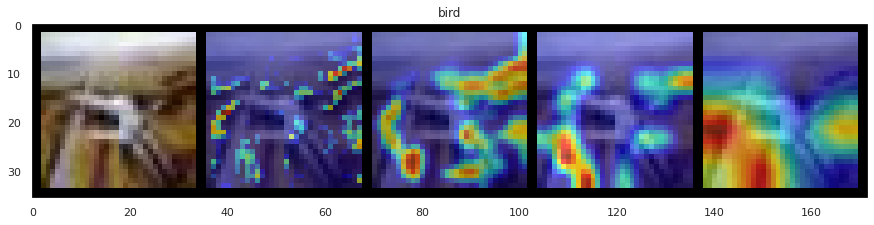

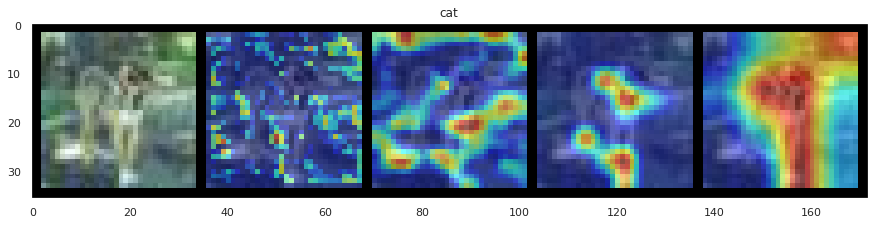

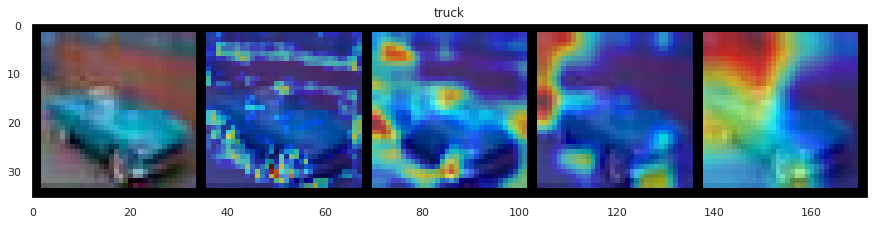

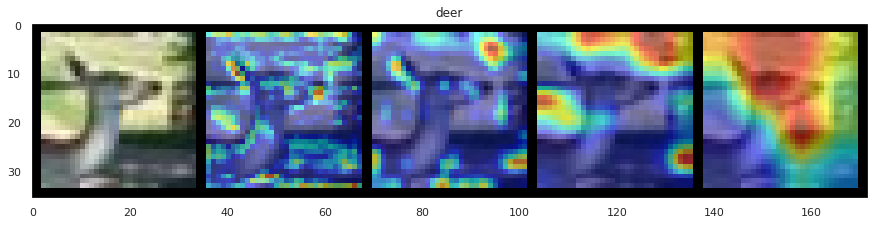

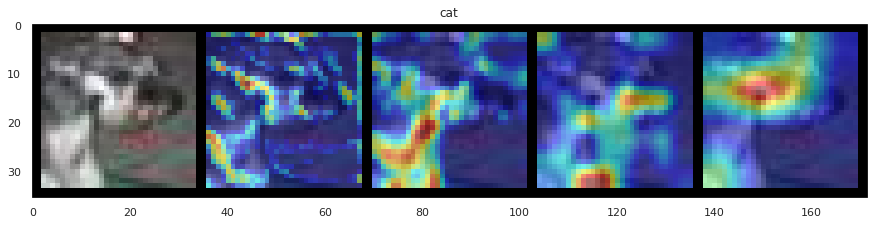

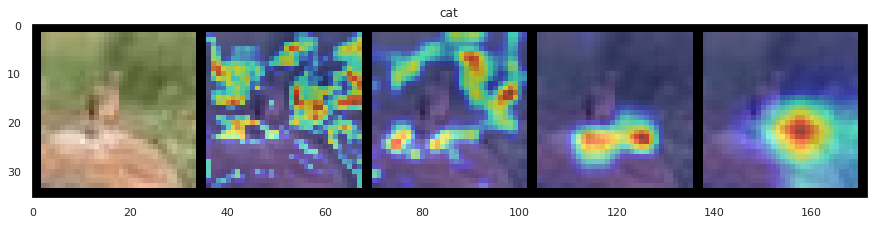

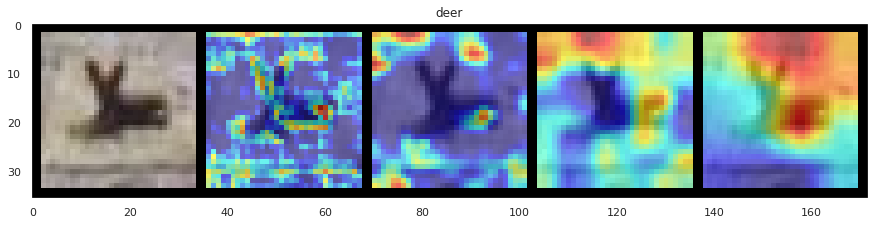

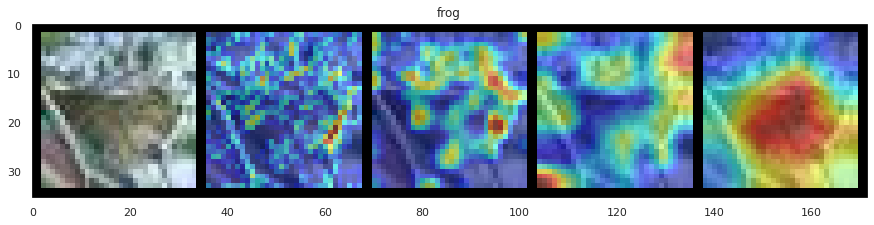

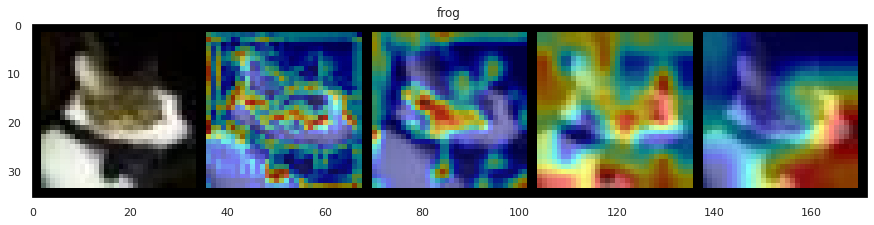

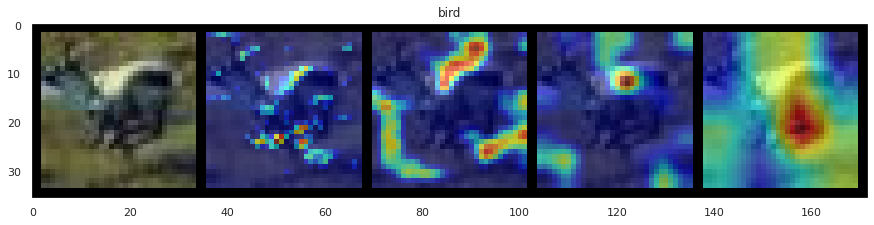

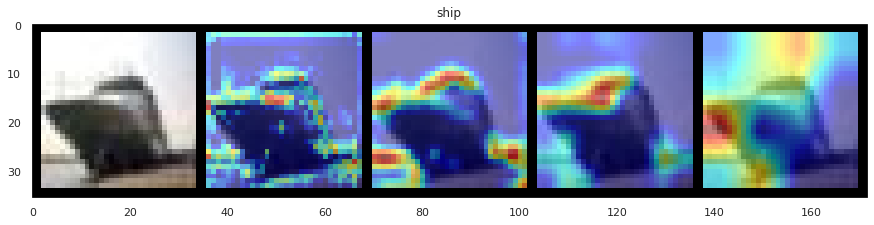

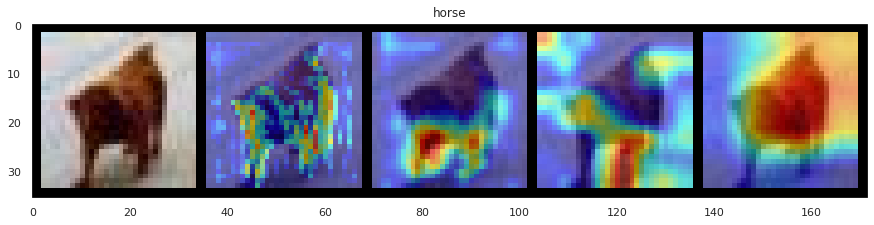

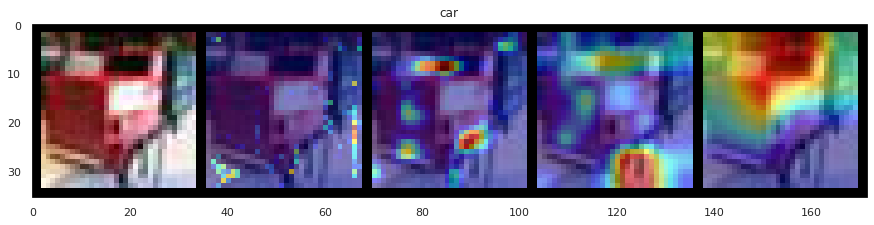

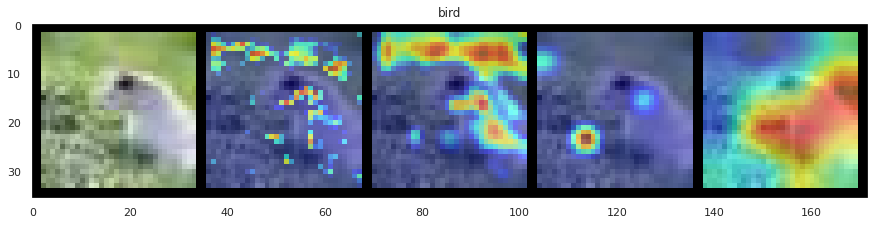

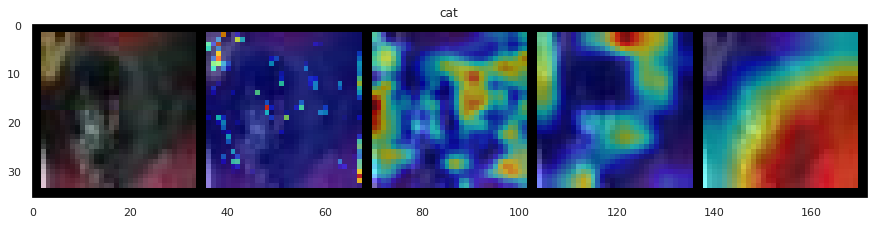

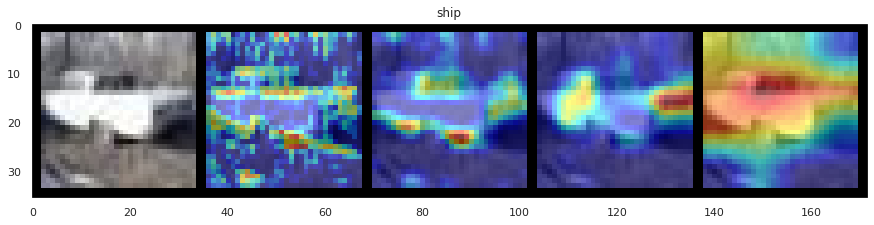

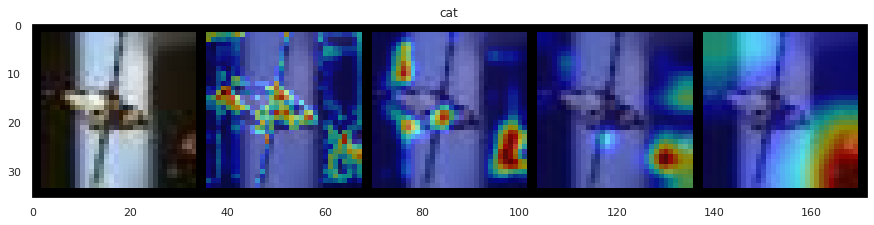

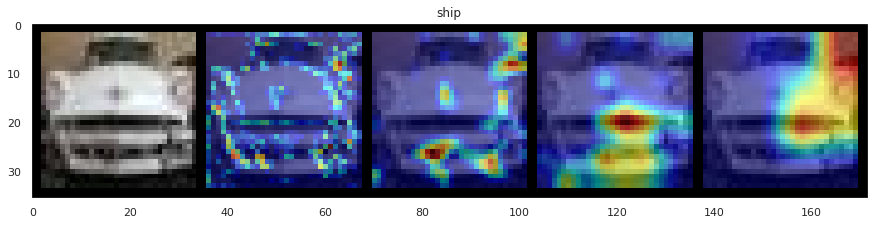

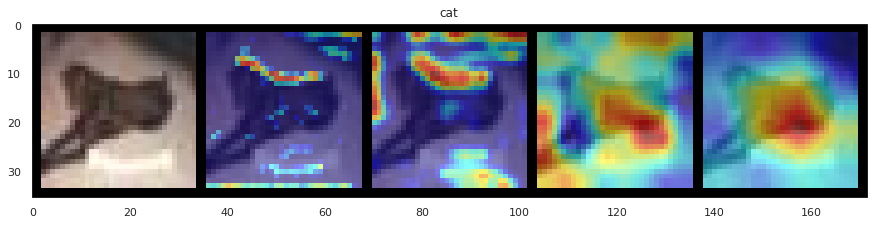

In [17]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])